# No the other one

Usual great [XKCD comic](https://xkcd.com/2480/) from Monroe.  Posting some code to replicate identification and plotting of cities that have names for which people immediately think of the more popular one. For example: Austin, Minnesota, not Austin, Texas.
- [Step 1](#import_cities) Import list of cities: source file manually downloaded from [here](https://simplemaps.com/data/us-cities)
- [Step 2](#find_cities) Find large city names that exist in other places
- [Step 3](#map_cities) Map it (see previous [blog post](https://www.meninderpurewal.com/data-meandering/us-maps-in-python) on US Maps)

In [1]:
import pandas as pd
import numpy as np

# for the plot
import matplotlib.pyplot as plt
import geopandas as gpd
import requests, zipfile, io, os

<a id='import_cities'></a>

## Import list of cities

In [2]:
columns = ['city', 'state_id', 'state_name', 'lat', 'lng', 'population']
df = pd.read_csv('uscities.csv', usecols=columns)
#df.describe()
df.head()

,city,state_id,state_name,lat,lng,population
0,New York,NY,New York,40.6943,-73.9249,18713220
1,Los Angeles,CA,California,34.1139,-118.4068,12750807
2,Chicago,IL,Illinois,41.8373,-87.6862,8604203
3,Miami,FL,Florida,25.7839,-80.2102,6445545
4,Dallas,TX,Texas,32.7936,-96.7662,5743938


<a id='find_cities'></a>

## Identify cities in other places

Identify large cities

In [3]:
city_count = df.groupby('city')['population'].count()
max_population = df.groupby('city')['population'].max()
multiple_cities1 = set(city_count[city_count > 1].index.values)
multiple_cities2 = set(max_population[max_population>1e6].index.values)
multiple_cities = list(set.intersection(multiple_cities1, multiple_cities2))

df = df[df['city'].isin(multiple_cities)]
df.shape

(246, 6)

For every city, get the second most populated entity

In [4]:
df = df.sort_values(by=['city', 'population'], ascending=[True, False]).groupby('city').head(2)
df = df.sort_values(by=['city', 'population'], ascending=[True, True]).groupby('city').head(1)

In [5]:
df.shape

(37, 6)

In [8]:
df.sort_values(by='population', ascending=False)

,city,state_id,state_name,lat,lng,population
173,Columbus,GA,Georgia,32.5100,-84.8771,261445
219,Portland,ME,Maine,43.6773,-70.2715,203969
291,Kansas City,KS,Kansas,39.1234,-94.7443,152960
413,Richmond,CA,California,37.9477,-122.3390,110567
424,Jacksonville,NC,North Carolina,34.7288,-77.3941,108856
651,Cleveland,TN,Tennessee,35.1817,-84.8707,73596
878,Manhattan,KS,Kansas,39.1886,-96.6046,57046
1650,Washington,UT,Utah,37.1304,-113.4877,29174
1875,Austin,MN,Minnesota,43.6718,-92.9783,25626
1912,Riverside,OH,Ohio,39.7836,-84.1219,25133


<a id='map_cities'></a>

## Map Cities

In [9]:
states = gpd.read_file('ShapeFolder/cb_2018_us_state_5m.shp')
states_remove = ['HI', 'VI', 'DC', 'GU', 'MP', 'AS', 'PR', 'AK']
states = states[~states['STUSPS'].isin(states_remove)]

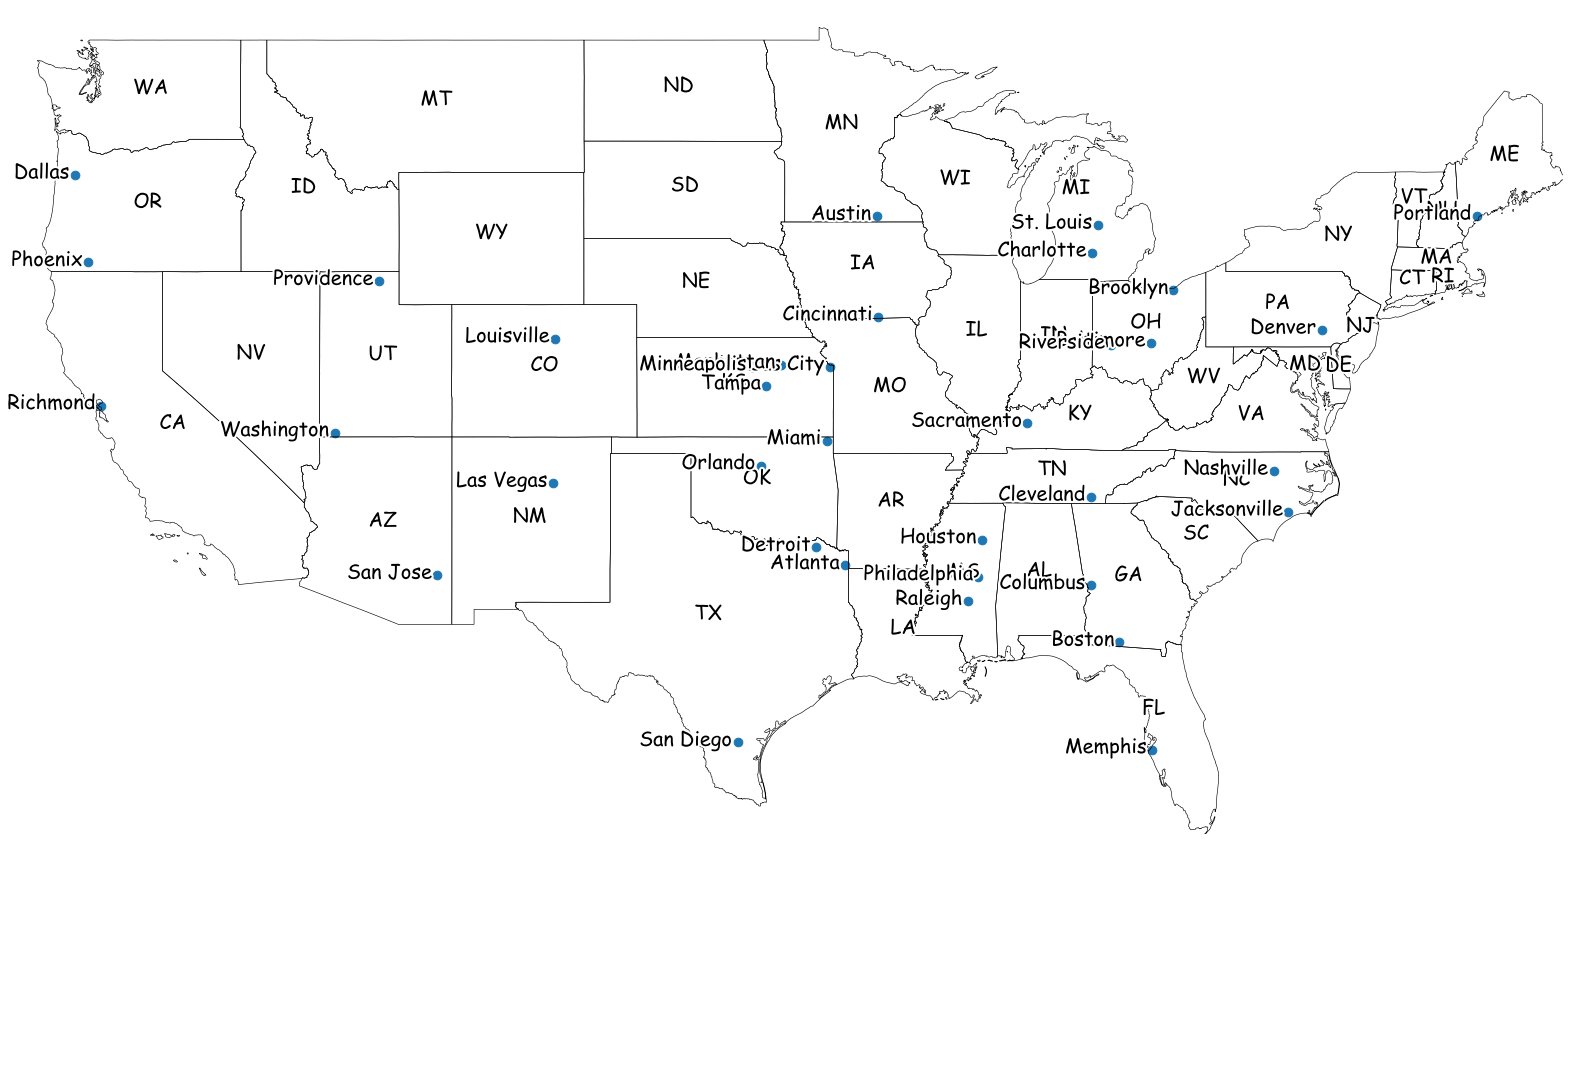

In [10]:
plt.xkcd()
fig = plt.figure(1, figsize=(30,15)) 
ax = fig.add_subplot()

states.boundary.plot(ax=ax, color='Black', linewidth=.6)
states.apply(lambda x: ax.annotate(text=x.STUSPS, 
                                   xy=x.geometry.centroid.coords[0], 
                                   ha='center', 
                                   fontsize=20),
             axis=1)
df.apply(lambda x: ax.annotate(text=x.city,
                              xy= (x.lng-.2, x.lat-.1),
                               ha='right',
                               fontsize=20),
         axis=1
        )
ax.scatter(df.lng, df.lat, marker='o', s=75)
#zoom in on lower 48 by trial and error
ax.set_xlim(-125,-67)
ax.set_ylim(25, 50)

#final touches
plt.axis('off')
plt.tight_layout()

fig.savefig('US_Map_XKCD2480.png', facecolor='w')